# Overview

    The goals of this project include the following:

  *  Implement pipelines for regression prediction problems
       * Exploratory data analysis
       * Date preprocessing
           * Data standardization
           * Deal with missing data
           * Dealing with categorical input features via, say, OHE
       * Linear regression modeling (regularized or not)
       * Various performance metrics
Overview on the project:

    The objective is to predict the number of bikes that will be rented using the provided data.
    Use various python packages like numpy, pandas, seaborn and standardScaler to explore the data and perform feature engineering.
    Finally build linear regression models as described in each task and evalaute them using the listed metric(s).


# Preparation
Import necessary libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Set style for Plotting
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

In [3]:
# random seed for reproduciility

np.random.seed(42)

## Load bike-sharing data

In [4]:
train=pd.read_csv('Kaggle-Bike-Sharing-Demand-Challenge/train.csv')
test=pd.read_csv('Kaggle-Bike-Sharing-Demand-Challenge/test.csv')


## EDA: Understanding the bike demand data det and doing EDA 

Understanding the Data Set
The dataset shows hourly rental data for two years (2011 and 2012). The training data set is for the first 19 days of each month. The test dataset is from 20th day to month’s end. We are required to predict the total count of bikes rented during each hour covered by the test set.

In the training data set, they have separately given bike demand by registered, casual users and sum of both is given as count.

Training data set has 12 variables (see below) and Test has 9 (excluding registered, casual and count).

Independent Variables

```
datetime:   date and hour in "mm/dd/yyyy hh:mm" format
season:     Four categories-> 1 = spring, 2 = summer, 3 = fall, 4 = winter
holiday:    whether the day is a holiday or not (1/0)
workingday: whether the day is neither a weekend nor holiday (1/0)
weather:    Four Categories of weather
            1-> Clear, Few clouds, Partly cloudy, Partly cloudy
            2-> Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            3-> Light Snow and Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
            4-> Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
temp:       hourly temperature in Celsius
atemp:      "feels like" temperature in Celsius
humidity:   relative humidity
windspeed:  wind speed
Dependent Variables

registered: number of registered user
casual:     number of non-registered user
count:      number of total rentals (registered + casual)
```
Notice the Training dataset has 3 target features:

```
registered: number of registered user
casual:     number of non-registered user
count:      number of total rentals (registered + casual)
```


** Here we will focus on predicting `count` feature initially.**

### Take a look at data

In [5]:

print("TRAIN", train.shape)
print("TEST", test.shape)

TRAIN (10886, 12)
TEST (6493, 9)


In [6]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Variables casual, registered and count are target variables. Count is sum of registered and casual.

In [7]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


### Check for missing values

In [8]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [9]:
## summary statistics of each variable
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


### Plot feature distributions including target: casual, registered and count

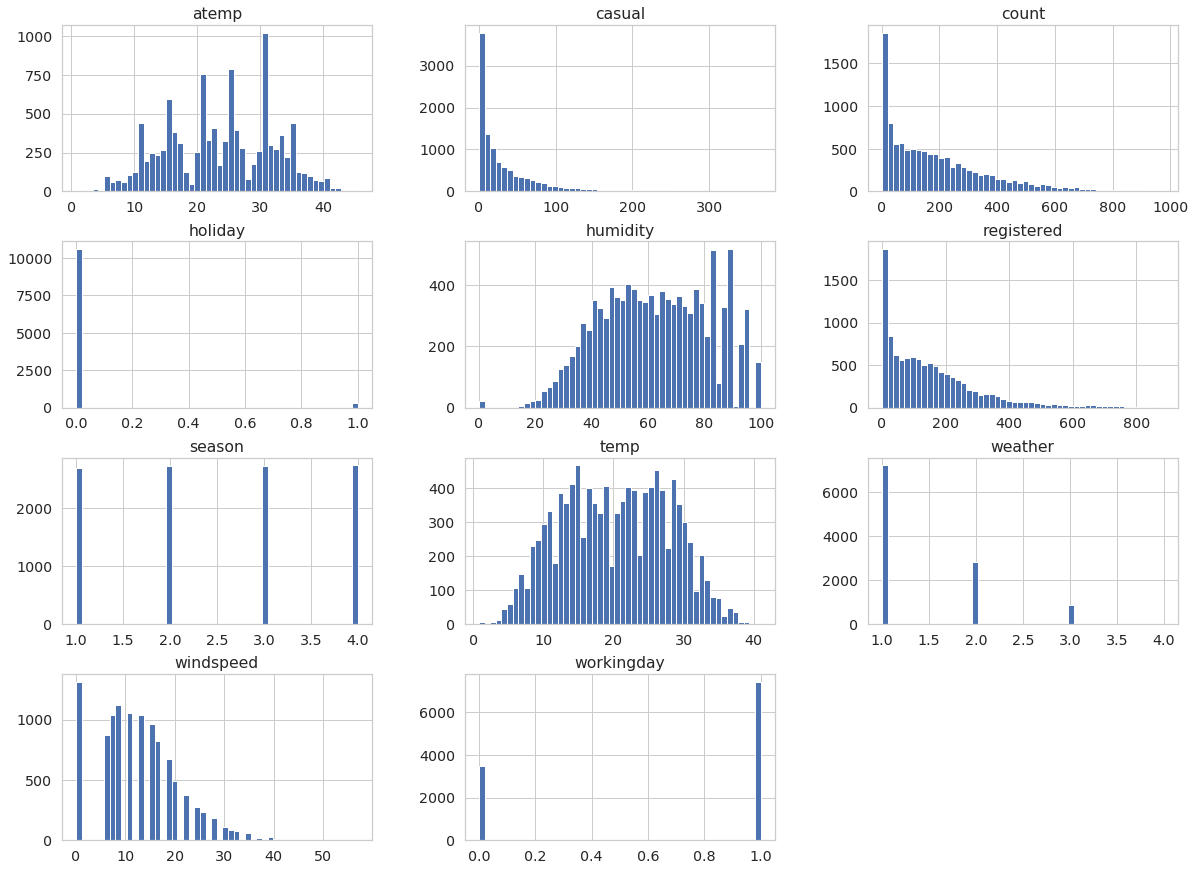

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
train.hist(bins=50, figsize=(20,15))
plt.show()

## One Hot Encoding (OHE)
Some of the features such as Season, Weather, holiday and working day are recorded in numerical formats. These numeric values do not have any particular numerical ordering. So it is better to one hot encode these features manually on both train and test data.

### OHE on weather, season and timestamp

In [11]:
# Create a new column called df.weather1 where the value is 1
# if df.weather is 1 and 0 if not
train['weather1'] = np.where(train['weather']==1, 1, 0)  #if else assignment
train['weather2'] = np.where(train['weather']==2, 1, 0)
train['weather3'] = np.where(train['weather']==3, 1, 0)
train['weather4'] = np.where(train['weather']==4, 1, 0)

# dont forget to drop the original feature
train.drop(['weather'], axis=1, inplace=True)

In [12]:
# Create a new column called df.season1 where the value is 1
# if df.season is 1 and 0 if not
train['season1'] = np.where(train['season']==1, 1, 0)  #ifelse assignment
train['season2'] = np.where(train['season']==2, 1, 0)
train['season3'] = np.where(train['season']==3, 1, 0)
train['season4'] = np.where(train['season']==4, 1, 0)

# dont forget to drop the original feature
train.drop(['season'], axis=1, inplace=True)

## Create new features hour, day, month, year from datetime

In [13]:
train["hour"] = [t.hour for t in pd.DatetimeIndex(train.datetime)]
train["day"] = [t.dayofweek for t in pd.DatetimeIndex(train.datetime)]
train["month"] = [t.month for t in pd.DatetimeIndex(train.datetime)]
train['year'] = [t.year for t in pd.DatetimeIndex(train.datetime)]
train['year'] = train['year'].map({2011:0, 2012:1}) #OHE: One-hot-encoding (OHE): 

##  Separate independent features and target on train set

In [14]:
X, y = train.iloc[:, 1:], train['count']
X = train.drop(['datetime','registered', 'casual', 'count'], axis=1)

In [15]:
X.iloc[0:2, :]

,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year
0,0,0,9.84,14.395,81,0.0,1,0,0,0,1,0,0,0,0,5,1,0
1,0,0,9.02,13.635,80,0.0,1,0,0,0,1,0,0,0,1,5,1,0


# Implement Machine Learning Models

## Split data into train and a test set (blind set)
Test set data that is already provided is for kaggle submission. So other dataset is splitted into train and a blind test set

In [16]:
from sklearn.model_selection import  train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

## Feature Selection

K best features are selected based on F score. The higher the F-score, more relevant is the feature.

In [17]:


def select_kbest_reg(data_frame, target, k=5):
    """
    Selecting K-Best features regression
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    feat_selector = SelectKBest(f_regression, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores
#X = pd.DataFrame(boston.data, columns=boston.feature_names)
#y = boston.target
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df = pd.DataFrame(X_train, columns=X_train.columns.unique()).copy()
df["count"] = y_train

per_feat = select_kbest_reg(df, 'count', k=7)
per_feat_sorted = per_feat.sort_values(["F Score", "P Value"], ascending=[False, False])
top_k_feature_indices = per_feat_sorted['Attribute'].values.flatten()
print("\n Feature Score for a linear regression using correlation\n")
print(per_feat_sorted) 

print(np.linalg.norm(y_train))


 Feature Score for a linear regression using correlation

        F Score        P Value  Support   Attribute
14  1469.911208  3.154155e-294     True        hour
2   1392.705790  4.188766e-280     True        temp
3   1345.313872  2.248222e-271     True       atemp
4    835.773721  1.817225e-174     True    humidity
17   521.712886  9.528069e-112     True        year
10   454.819272   4.547750e-98     True     season1
16   230.585036   2.494882e-51     True       month
12   136.114875   3.464712e-31    False     season3
8    107.764635   4.446058e-25    False    weather3
6     85.064471   3.675809e-20    False    weather1
5     76.400544   2.815192e-18    False   windspeed
11    42.362122   8.064916e-11    False     season2
7     12.939829   3.237028e-04    False    weather2
13     6.961529   8.345025e-03    False     season4
1      1.910518   1.669462e-01    False  workingday
15     1.866755   1.718875e-01    False         day
0      0.033480   8.548221e-01    False     holiday
9    

## Feature Importances Based on F-score

In [18]:
feature_importances = per_feat[["F Score", "Attribute"]] #Order of appearence in dataframe
feature_importances_sorted = per_feat_sorted[["F Score", "Attribute"]] #Order of appearence in dataframe
feature_importances

,F Score,Attribute
0,0.033480,holiday
1,1.910518,workingday
2,1392.705790,temp
3,1345.313872,atemp
4,835.773721,humidity
5,76.400544,windspeed
6,85.064471,weather1
7,12.939829,weather2
8,107.764635,weather3
9,0.021070,weather4


Based on F-score and p-values hour, temp, humidity, season1, year are some of the important features.

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

# find the indices to the top ranking input features based on importance 
#    arr is an array of feature importances in order of the input data matrix X
#    k is the number of features to be selected
#
# Note: this feature selector assumes that you have already computed the feature importances 
# somehow (for example using SelectKBest or through a RandomForestRegressor decision tree ensemble). 
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    # select the columns of data matrix of the selected input features 
    def transform(self, X):
        return X[:, self.feature_indices_]

Important features based on F-score

In [20]:
k=7
featureScores = feature_importances[["F Score"]].values.flatten()
tf = TopFeatureSelector(featureScores, k)
tf.fit(X_train)
print(tf.feature_indices_)
#X_train[:,tf.feature_indices_]
X_train.values[:,tf.feature_indices_]

[ 2  3  4 10 14 16 17]


array([[32.8  , 37.12 , 52.   , ..., 13.   ,  8.   ,  1.   ],
       [32.8  , 35.605, 36.   , ..., 18.   ,  8.   ,  1.   ],
       [ 4.92 ,  6.82 , 50.   , ...,  9.   ,  2.   ,  1.   ],
       ...,
       [27.06 , 31.06 , 39.   , ..., 14.   , 10.   ,  1.   ],
       [14.76 , 17.425, 87.   , ...,  9.   , 12.   ,  1.   ],
       [33.62 , 35.605, 30.   , ..., 18.   ,  7.   ,  0.   ]])

## Feature Selection and Linear Regression Pipeline

In [21]:
k = 7
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#('preparation', ......stand),
#SKLearn's linear regression pipeline

lr_pipeline = Pipeline([
        ("std_scaler", StandardScaler()),
        ('feature_selection', TopFeatureSelector(featureScores, k)),
        ('lineReg', LinearRegression())
    ])
#print(preparation_and_feature_selection_pipeline)
lr_pipeline.fit(X_train.values, y_train) 
#bike_sharing_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(X_train.values)

Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', TopFeatureSelector(feature_importances=array([3.34800e-02, 1.91052e+00, 1.39271e+03, 1.34531e+03, 8.35774e+02,
       7.64005e+01, 8.50645e+01, 1.29398e+01, 1.07765e+02, 2.10697e-02,
       4.54819...   k=7)), ('lineReg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

The model above is implemented using top 7 important features selected from feature_selection function.

# Model Evaluation

In [22]:
results = pd.DataFrame(columns= ["LR Model", "RMSE", "MAE", "Rsquare"])

In [23]:
expLog = pd.DataFrame(columns=["Model description", "RMSE train", 'Train Time', 'RMSE test', 'Test Time'])

In [25]:
train_predictions = lr_pipeline.predict(X_train)
test_predictions = lr_pipeline.predict(X_test)



In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
start = time.time()
train_time = time.time() - start
test_time = time.time() - start

RMSE_train =  np.sqrt(mean_squared_error(y_train, train_predictions))
RMSE_test = np.sqrt(mean_squared_error(y_test + 1, test_predictions))

MAE_train = mean_absolute_error(y_train, train_predictions) 
MAE_test = mean_absolute_error(y_test, test_predictions)
r2_train =r2_score(y_train, train_predictions)   
r2_test = r2_score(y_test, test_predictions)
     
expLog.loc[len(expLog)] = ["SKLearn Linear Regression",
                           np.round(np.sqrt(mean_squared_error(y_train, train_predictions)),3),
                           train_time,
                           np.round(np.sqrt(mean_squared_error(y_test, test_predictions)),3),
                           test_time]

## Results

In [27]:
# add the result of this experiment ot the log book
results.loc[len(results)] = ['SKlearn Train', np.round(RMSE_train, 3), np.round(MAE_train, 3), np.round(r2_train, 2) ]

In [28]:
results.loc[len(results)] = ['SKlearn Test', np.round(RMSE_test, 3), np.round(MAE_test, 3), np.round(r2_test, 2) ]

In [29]:
results

,LR Model,RMSE,MAE,Rsquare
0,SKlearn Train,141.953,106.298,0.39
1,SKlearn Test,140.950,105.664,0.39


# Decision Trees

In [30]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import time
scl= StandardScaler()
X_train_std = scl.fit_transform(X_train)
X_test_std = scl.transform(X_test)
dt = DecisionTreeRegressor()
start = time.time()
dt.fit(X_train_std, y_train)
y_train_pred = dt.predict(X_train_std)
train_time = time.time() - start

start = time.time()
y_test_pred = dt.predict(X_test_std)
test_time = time.time() - start


print('RMSE train: %.3f' % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('RMSE test: %.3f' % np.sqrt(mean_squared_error(y_test + 1, y_test_pred)))
     
      
expLog.loc[len(expLog)] = ["SKLearn DecisionTreeRegressor",
                           np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)),3),
                           train_time,
                           np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)),3),
                           test_time]

RMSE train: 0.276
RMSE test: 62.322


# RandomForest Regressor

In [31]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 400, criterion='mse',random_state=1, n_jobs=-1)
start = time.time()
forest.fit(X_train_std, y_train)
train_pred = forest.predict(X_train_std)
train_time = time.time() - start

start = time.time()
test_pred = forest.predict(X_test_std)
test_time = time.time() - start

In [32]:
print('RMSE train: %.3f' % np.sqrt(mean_squared_error(y_train, train_pred)))
print('RMSE test: %.3f' % np.sqrt(mean_squared_error(y_test + 1, test_pred)))     
      
expLog.loc[len(expLog)] = ["SKLearn RandomForestRegressor",
                           np.round(np.sqrt(mean_squared_error(y_train, train_pred)),3),
                           train_time,
                           np.round(np.sqrt(mean_squared_error(y_test, test_pred)),3),
                           test_time]

RMSE train: 14.955
RMSE test: 42.512


Higher RSME value for test data compared to train shows the model is overfitted. Such result is observed for both DecisionTree as well as RandomForest models. Both of these models are not trained over top k features. 

In [33]:
expLog

,Model description,RMSE train,Train Time,RMSE test,Test Time
0,SKLearn Linear Regression,141.953,0.000034,140.940,0.000066
1,SKLearn DecisionTreeRegressor,0.276,0.105325,62.346,0.000845
2,SKLearn RandomForestRegressor,14.955,18.321522,42.532,0.627792


# OHE on test data

In [34]:
# Create a new column called df.weather1 where the value is 1
# if df.weather is 1 and 0 if not
test['weather1'] = np.where(test['weather']==1, 1, 0)  #ifelse assignment
test['weather2'] = np.where(test['weather']==2, 1, 0)
test['weather3'] = np.where(test['weather']==3, 1, 0)
test['weather4'] = np.where(test['weather']==4, 1, 0)

# dont forget to drop the original feature
test.drop(['weather'], axis=1, inplace=True)

In [35]:
test['season1'] = np.where(test['season']==1, 1, 0)  #if else assignment
test['season2'] = np.where(test['season']==2, 1, 0)
test['season3'] = np.where(test['season']==3, 1, 0)
test['season4'] = np.where(test['season']==4, 1, 0)

# dont forget to drop the original feature
test.drop(['season'], axis=1, inplace=True)

In [36]:
test["hour"] = [t.hour for t in pd.DatetimeIndex(test.datetime)]
test["day"] = [t.dayofweek for t in pd.DatetimeIndex(test.datetime)]
test["month"] = [t.month for t in pd.DatetimeIndex(test.datetime)]
test['year'] = [t.year for t in pd.DatetimeIndex(test.datetime)]
test['year'] = test['year'].map({2011:0, 2012:1})


In [37]:
test.tail()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,weather1,weather2,weather3,weather4,season1,season2,season3,season4,hour,day,month,year
6488,2012-12-31 19:00:00,0,1,10.66,12.880,60,11.0014,0,1,0,0,1,0,0,0,19,0,12,1
6489,2012-12-31 20:00:00,0,1,10.66,12.880,60,11.0014,0,1,0,0,1,0,0,0,20,0,12,1
6490,2012-12-31 21:00:00,0,1,10.66,12.880,60,11.0014,1,0,0,0,1,0,0,0,21,0,12,1
6491,2012-12-31 22:00:00,0,1,10.66,13.635,56,8.9981,1,0,0,0,1,0,0,0,22,0,12,1
6492,2012-12-31 23:00:00,0,1,10.66,13.635,65,8.9981,1,0,0,0,1,0,0,0,23,0,12,1


In [40]:
X_t=test.iloc[:,1:]

In [41]:
X_t.shape

(6493, 18)

# Predictions on test set

In [42]:
X_t = scl.transform(X_t)

In [43]:
y_t=forest.predict(X_t)

In [44]:
lr_pipeline.fit(X_t, y_t)

Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', TopFeatureSelector(feature_importances=array([3.34800e-02, 1.91052e+00, 1.39271e+03, 1.34531e+03, 8.35774e+02,
       7.64005e+01, 8.50645e+01, 1.29398e+01, 1.07765e+02, 2.10697e-02,
       4.54819...   k=7)), ('lineReg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [45]:
y_predictions = lr_pipeline.predict(X_t)

In [47]:
df_submit = test

In [48]:
df_submit['count'] = np.round(y_predictions)

In [49]:
df_submit = df_submit.drop(['season1', 'season2', 'season3', 'season4', 'holiday', 'workingday','temp', 'atemp', 'humidity', 
                            'windspeed', 'hour', 'day', 'month', 'year', 'weather1', 'weather2',
                            'weather3', 'weather4'], axis=1)

In [50]:
df_submit.head()

,datetime,count
0,2011-01-20 00:00:00,-37.0
1,2011-01-20 01:00:00,-22.0
2,2011-01-20 02:00:00,-14.0
3,2011-01-20 03:00:00,-8.0
4,2011-01-20 04:00:00,0.0


In [52]:
# converting negative count values as zero
df_submit['count'] = np.where(df_submit['count'] < 0, 0, df_submit['count'])

In [54]:
df_submit.head()

,datetime,count
0,2011-01-20 00:00:00,0.0
1,2011-01-20 01:00:00,0.0
2,2011-01-20 02:00:00,0.0
3,2011-01-20 03:00:00,0.0
4,2011-01-20 04:00:00,0.0


In [55]:
df_submit.tail()

,datetime,count
6488,2012-12-31 19:00:00,264.0
6489,2012-12-31 20:00:00,272.0
6490,2012-12-31 21:00:00,280.0
6491,2012-12-31 22:00:00,298.0
6492,2012-12-31 23:00:00,288.0
